In [1]:
import pandas as pd
import numpy as np
import torch

import common.logger as logger
import common.dataset as dataset
import common.record as record
import common.trainer as trainer
import common.models as models
import common.preprocessing as pp
import common.utils as utils

from datetime import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import sys
import numpy as np
import cv2
from tqdm import tqdm
from collections import Counter
import os

/opt/conda/envs/development/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/envs/development/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Model loading from record
- Loads model from record
- Record is described in common.record

In [14]:
DEVICE = "cuda:0"
DEVICE = torch.device(DEVICE)
READ = False
record_path = "../records/archive/regression_new_test_resnet18/test.pt"

recorder = record.Record.load(record_path)
model = recorder.model
model = model.to(DEVICE)
model.eval()

test_dataset = recorder.test_dataset
transforms = test_dataset.transform

a = model.load_state_dict(recorder.checkpoints['best'])
print(f"Loaded train record from: {record_path}")

print(transforms)
print(recorder.test_dataset.root_dir)

Loaded train record from: ../records/archive/regression_new_test_resnet18/test.pt
Compose(
    ToTensor()
    Resize(size=(1024, 1024), interpolation=bilinear, max_size=None, antialias=False)
    HistogramStretching()
    ToRGBImage()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/donik/datasets/XPCI/dataset_biopsies_small


### Dataset preparation 
- Loads dataset depending on the protocol

In [21]:
PROTOCOL = "combined-multi" # fresh-multi, fresh-binary, archive-multi, combined-multi, combined-binary, archive-binary, archive-patches, fresh-patches
CSV_LOCATION = "../data/csv"
ROOT_DIR = "/home/donik/datasets/XPCI/dataset_biopsies_small"


if PROTOCOL == "fresh-multi":
    csv_path = CSV_LOCATION + '/fresh/test.csv'
    two_class = False
    pred_fn = models.regression_pred_fn
elif PROTOCOL == "fresh-binary":
    csv_path = CSV_LOCATION + '/fresh/test.csv'
    two_class = True
    pred_fn = models.regression_pred_fn
elif PROTOCOL == "archive-multi":
    csv_path = CSV_LOCATION + '/archive/test.csv'
    two_class = False
    pred_fn = models.regression_pred_fn
elif PROTOCOL == "archive-binary":
    csv_path = CSV_LOCATION + '/archive/test.csv'
    two_class = True
    pred_fn = models.regression_pred_fn
elif PROTOCOL == "combined-multi":
    csv_path = CSV_LOCATION + '/combined/test.csv'
    two_class = False
    pred_fn = models.regression_pred_fn
elif PROTOCOL == "combined-binary":
    csv_path = CSV_LOCATION + '/combined/test.csv'
    two_class = True
    pred_fn = models.regression_pred_fn
elif PROTOCOL == "archive-patches":
    csv_path = '/home/donik/datasets/XPCI/dataset_biopsies/csv/patches_archive/test.csv'
    ROOT_DIR = "/home/donik/datasets/XPCI/dataset_biopsies_patches"
    two_class = False
    pred_fn = models.classification_pred_fn
elif PROTOCOL == "fresh-patches":
    csv_path = CSV_LOCATION + '/patches_new/test.csv'
    ROOT_DIR = "/home/ssd/dataset_biopsies_patches_fresh_192"
    two_class = False
    pred_fn = models.classification_pred_fn

df = pd.read_csv(csv_path)
data_set = dataset.TestBiopsiesCSVDataset(df, ROOT_DIR, transform=transforms, two_class=two_class, preload=False, cache=False)

In [22]:
def evaluate_on_patches(df, classes = 3):
    # Group by original_image and sub_image to calculate percentage of positive predictions per sub_image
    percentage_positive_per_sub_image = df.groupby(['original_image'])['pred'].mean() * 100

    # Group by original_image to get the mean percentage of positive predictions per original_image
    mean_percentage_positive_per_image = percentage_positive_per_sub_image.groupby('original_image').mean()

    # Merge this result back to the original dataframe to group by original_target
    df = df.merge(mean_percentage_positive_per_image.rename('percentage_positive'), on='original_image')
    
    # Now group by original_target and calculate the mean of percentage_positive
    mean_percentage_positive_per_target = df.groupby('original_target')['percentage_positive'].mean()
    print(mean_percentage_positive_per_target)
    closest_target_index = df.percentage_positive.map(lambda x: (mean_percentage_positive_per_target - x).abs().idxmin())#.map(lambda x: 0 if x == 0 else x + 1)
    df_ret = df.assign(pred1=closest_target_index)

    from skimage.filters import threshold_multiotsu
    hist = np.histogram(df.percentage_positive, bins=100)
    thresholds = threshold_multiotsu(hist=hist, classes=classes)
    def clasify(x):
        if x < thresholds[0]:
            return 0
        elif x < thresholds[1]:
            return 2
        else:
            return 3
    df_ret["pred2"] = df.percentage_positive.apply(clasify)
    print(thresholds)

    return df_ret

In [23]:
print(model)

VariableEncoderClassificationModelNew(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, moment

In [24]:

csv_path = os.path.join(os.path.split(record_path)[0],'test.csv')

if not READ:
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False, num_workers=0)
    results = {}
    for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
        with torch.autocast(device_type=DEVICE.type, dtype=torch.float16):
            inputs, (labels, ids) = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                outputs = model(inputs)
                preds = pred_fn(outputs)
                for i in range(len(preds)):
                    results[ids[i]] = preds[i].item()
    print(results)

if READ:
    df1 = pd.read_csv(csv_path)
else:
    df1 = df.loc[df.image == list(results.keys())].assign(pred = list(results.values()))
    df1.to_csv(csv_path, index=False)

if "patches" in PROTOCOL:
    df_ret = evaluate_on_patches(df1)
    targets, preds = df_ret.original_target.values, df_ret.pred1.values
    df1 = df_ret
else:
    targets, preds = df1.target.values, df1.pred.values
cr = utils.createClassificationReport(targets, preds)
print(cr)


              precision    recall  f1-score   support

           0       0.86      0.81      0.83      7648
           1       0.58      0.92      0.71      2170
           2       0.93      0.87      0.90      2421
           3       0.98      0.75      0.85      2881

    accuracy                           0.82     15120
   macro avg       0.84      0.84      0.82     15120
weighted avg       0.85      0.82      0.83     15120



In [25]:

def classification_report(df1, typ, f, patches):
    if patches:
        targets, preds = df1[df1.type == typ].original_target.values, df1[df1.type == typ].pred2.values
    else:    
        targets, preds = df1[df1.type == typ].target.values, df1[df1.type == typ].pred.values
    if targets.size > 0:
        cr = utils.createClassificationReport(targets, preds)
        cr2 = utils.createClassificationReport([0 if t < 2 else 1 for t in targets], [0 if t < 2 else 1 for t in preds])
        print(f"{typ.capitalize()} task --------------- \n", cr, "\n", cr2, "\n", file=f)
        print(f"{typ.capitalize()} task --------------- \n", cr, "\n", cr2, "\n")

with open(os.path.join(os.path.split(record_path)[0],'results.txt'), 'w') as f:
    classification_report(df1, 'archive', f, 'patches' in PROTOCOL)
    classification_report(df1, 'fresh', f, 'patches' in PROTOCOL)

ValueError: Shape of passed values is (4, 4), indices imply (3, 3)

In [172]:
def classification_report_biopsy(df1, typ, f, patches):
    if patches:
        targets, preds = df1[df1.type == typ].groupby('biopsy').original_target.max(), df1[df1.type == typ].groupby('biopsy').pred2.max()
    else:    
        targets, preds = df1[df1.type == typ].groupby('biopsy').target.max(), df1[df1.type == typ].groupby('biopsy').pred.max()
        print(preds)
    if targets.size > 0:
        cr = utils.createClassificationReport(targets, preds)
        cr2 = utils.createClassificationReport([0 if t < 2 else 1 for t in targets], [0 if t < 2 else 1 for t in preds])
        print(f"{typ.capitalize()} task --------------- \n", cr, "\n", cr2, "\n", file=f)
        print(f"{typ.capitalize()} task --------------- \n", cr, "\n", cr2, "\n")


with open(os.path.join(os.path.split(record_path)[0], 'results_bio.txt'), 'w') as f:
    classification_report_biopsy(df1, 'archive', f, 'patches' in PROTOCOL)
    classification_report_biopsy(df1, 'fresh', f, 'patches' in PROTOCOL)

biopsy
rec_8bit_07    3.0
rec_8bit_12    0.0
rec_8bit_19    1.0
rec_8bit_33    0.0
Name: pred, dtype: float64
Archive task --------------- 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.62      0.75      0.67         4
weighted avg       0.62      0.75      0.67         4
 
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4
 

biopsy
014_101_08_HA_S2_    0.0
38_201-01.2_S2       2.0
49_101-55.5_S3       1.0
Name: pred,

/opt/conda/envs/development/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/development/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/development/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

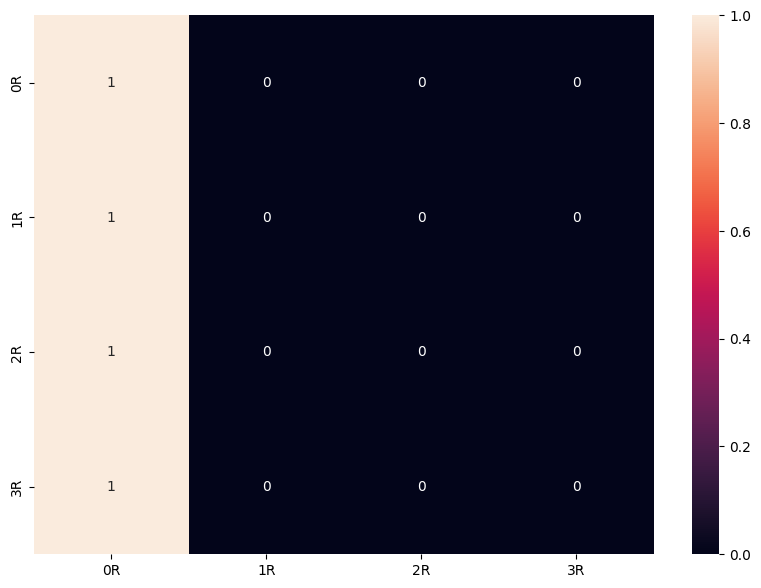

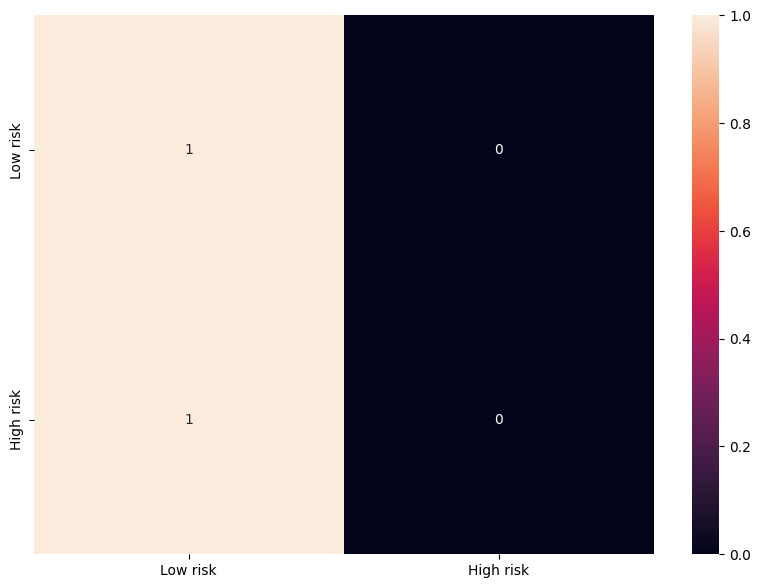

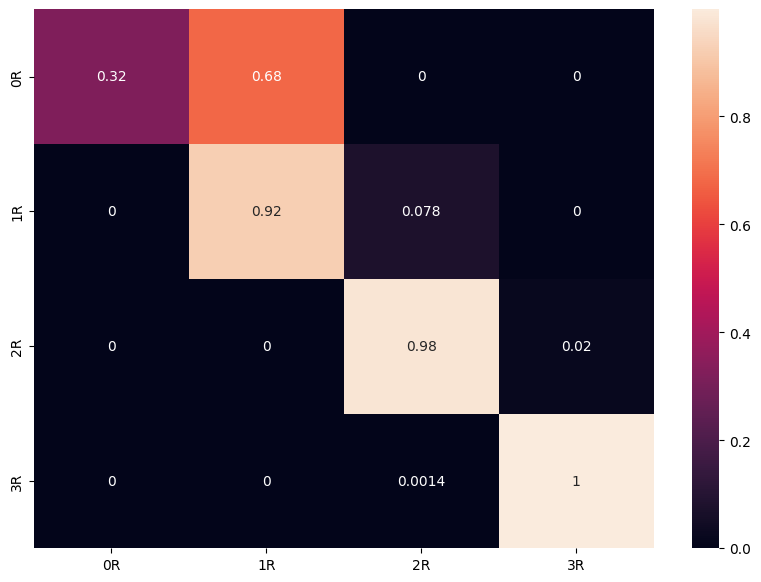

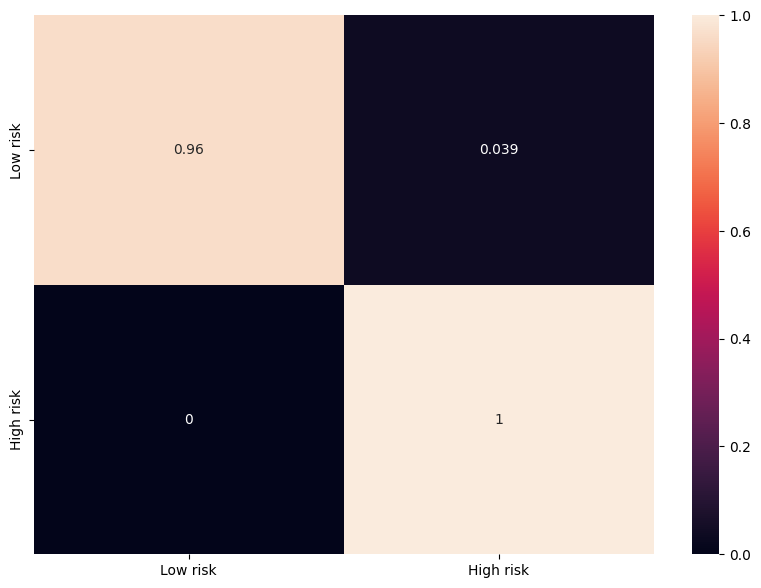

In [29]:
from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def conf(df1, typ, patches):
    if patches:
        targets, preds = df1[df1.type == typ].original_target.values, df1[df1.type == typ].pred2.values
    else:    
        targets, preds = df1[df1.type == typ].target.values, df1[df1.type == typ].pred.values
    if targets.size > 0:
        cr = confusion_matrix(targets, preds, normalize="true")
        cr2 = confusion_matrix([0 if t < 2 else 1 for t in targets], [0 if t < 2 else 1 for t in preds], normalize="true")
        return cr, cr2


cm, cm2 = conf(df1, 'fresh', 'patches' in PROTOCOL)
trgts = ["0R", "2R", "3R"] if "patches" in PROTOCOL else ["0R", "1R", "2R", "3R"]
df_cm = pd.DataFrame(cm, index = trgts,
                  columns = trgts)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

df_cm = pd.DataFrame(cm2, index = ["Low risk", "High risk"],
                  columns = ["Low risk", "High risk"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

if 'patches' not in PROTOCOL:
    cm, cm2 = conf(df1, 'archive', 'patches' in PROTOCOL)

    df_cm = pd.DataFrame(cm, index = ["0R", "1R", "2R", "3R"],
                    columns = ["0R", "1R", "2R", "3R"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

    df_cm = pd.DataFrame(cm2, index = ["Low risk", "High risk"],
                    columns = ["Low risk", "High risk"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()
